<a href="https://colab.research.google.com/github/Sbu97/AI_in_built_environments_sbusiso_IAAC2024_tutorials_/blob/main/DimensionalityReduction_AE_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [1]:
# pip installs
!pip install tensorflow keras matplotlib

In [5]:
# System & Colab
from google.colab import widgets
from google.colab import files
from google.colab import drive
import io, os
import requests, zipfile, glob

# utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Data manipulation
import json
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
# pillow

# ML
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split



## Importing the Data

We will use an image dataset in this excerise. It consists of ca. 3000 images depicting different buildings and architectural styles. The images are resized and converted to grayscale to speed up model training and experimentation. Note: most the algorithms shown below work also with tabular data!
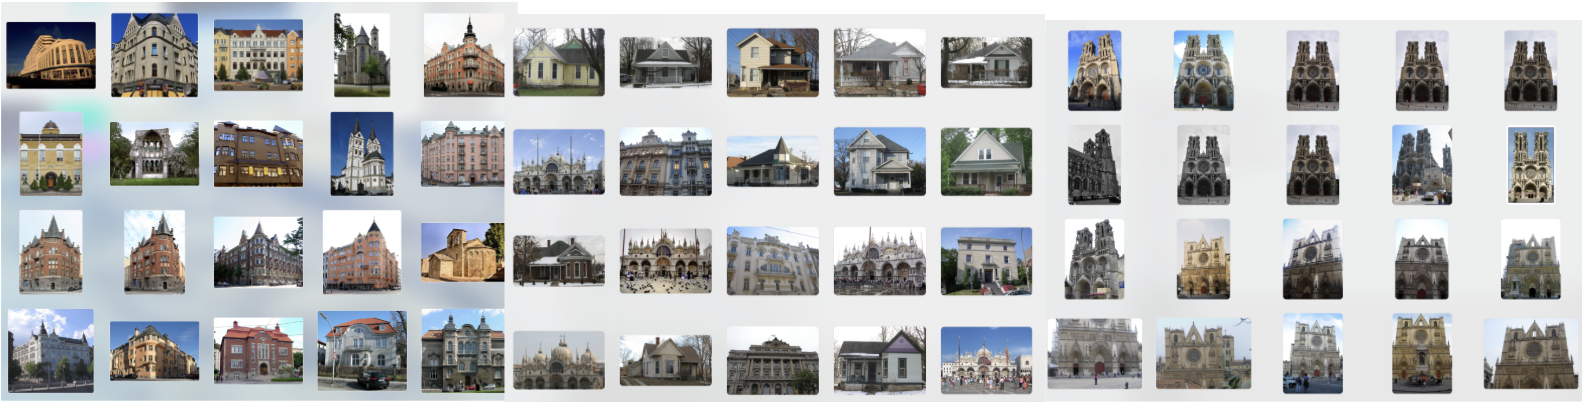

**Step 1** Upload *`ArchCombinedSmall.zip`*
-> use the `files icon` on side bar -> then hit `upload`

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Unzipping the uploaded dataset
zip_path = '/content/drive/MyDrive/2nd year/AI in Built Environments/week 4/ArchCombinedSmall (1).zip'
unzip_location = '/content/ArchCombinedSmall'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_location)

In [8]:
# load all the images
image_files = glob.glob('/content/ArchCombinedSmall/ArchCombinedSmall/*.jpg')

### Data Processing & Scaling

Since we apply PCA, UMAP and a basic Autoencoder directly on our image data, we:


*   down scale their size
*   grayscale them
*   turn them into numpy arrays (matrices)



In [9]:
# Function to load and preprocess images
def load_and_preprocess_image(path, target_size=(64, 64), flatten=False):
    image = load_img(path, color_mode='grayscale', target_size=target_size)
    image_array = img_to_array(image)
    if flatten:
      # flatten to 2D array, normalize to 0-1
      return image_array.flatten() / 255.0
    else:
      # normalize to 0-1
      return image_array / 255.0


# Dimensionality Reduction
Dimensionality reduction is a technique used in data analysis and machine learning to simplify complex datasets with many features (or dimensions) into a form that's easier to understand and work with.


---

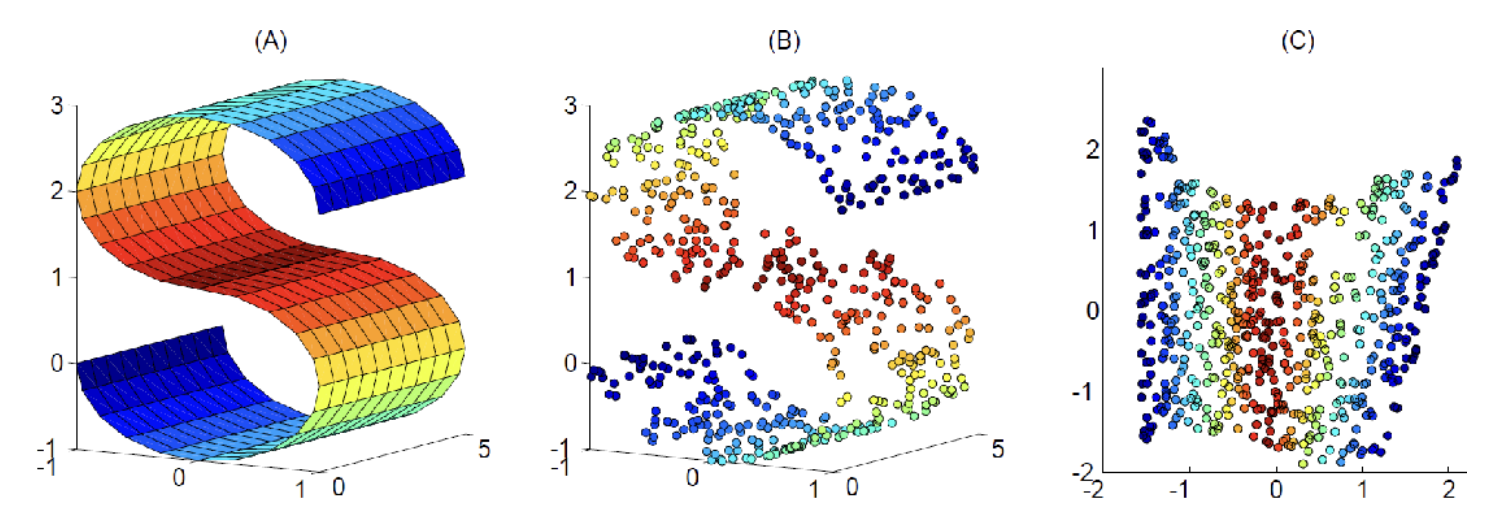

# Approach 1: Principal Component Analysis

### Pros
1. **Efficiency in High-Dimensional Data**: PCA is particularly effective for datasets with a large number of dimensions, simplifying complexity with minimal loss of information.
2. **Noise Reduction**: It helps in filtering out noise from the dataset by keeping only the most significant features.
3. **Improved Visualization**: By reducing dimensions, PCA makes it easier to visualize and interpret data, especially when reducing to two or three principal components.

### Cons
1. **Linear Limitations**: PCA assumes linearity in the data and is less effective for non-linear data structures.
2. **Variance-Centric**: It focuses solely on maximizing variance, which might not always represent the most important features.
3. **Data Scaling Dependent**: PCA is sensitive to the scaling of the features, requiring standardization for meaningful results.

### When to Use
- Use PCA when dealing with high-dimensional data and you need to simplify it for analysis or visualization.
- It's particularly useful in pre-processing steps for machine learning, especially when computational efficiency is important.
- Ideal for linear data where the principal components can capture most of the variation in the data.


In [10]:
# import additional libaries
from sklearn.decomposition import PCA

In [11]:
# load images (flattend to 2D arrays)
images_matrix = np.array([load_and_preprocess_image(img_path, (128,128), flatten=True) for img_path in image_files])

In [12]:
images_matrix.shape

(2564, 16384)

In [18]:
# Initialize PCA object
pca_obj = PCA(n_components = 2)
# train pca with data
pca_out = pca_obj.fit_transform(images_matrix)



In [19]:
# Explained variation per principal component:
print(sum(pca_obj.explained_variance_ratio_))

0.2922745794057846


In [ ]:
pca_out

In [22]:
# safe to dataframe, rename columns as principal component 1 & 2
pca_df = pd.DataFrame(data=pca_out, columns =["pc1","pc2"])

In [23]:
pca_df.head()

pc1        pc2
0  30.428089   8.046227
1  -6.758401  20.675009
2 -15.497205 -17.628969
3 -18.783466  -2.794832
4   2.742993   8.126791

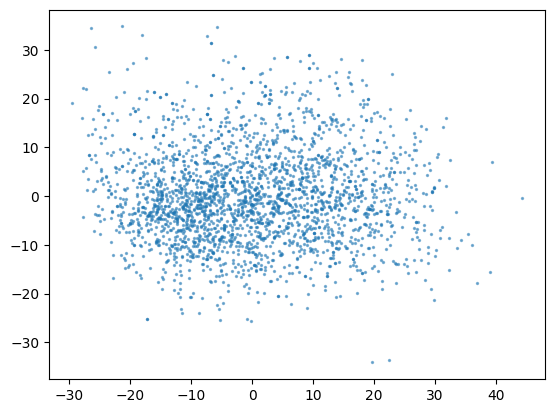

In [24]:
# plot PCA result
plt.scatter(pca_df['pc1'], pca_df['pc2'],s=2,  alpha=0.5)
plt.show()

In [25]:
# assumes greyscale iamges (one color channel)
def plot_images_on_scatter(images, x, y, num_samples=50, thumbnail_scale=0.05, fig_size=(12, 8)):

    plt.figure(figsize=fig_size)
    # Check if the images array is more than 1D and grab the image shape
    if images.ndim > 1:
        image_shape = images.shape[1:]  # This gets the shape of individual images
    else:
        raise ValueError("Images need to have more than one dimension")

    # Randomly select a subset of images and their corresponding x and y
    if num_samples < len(images):
        indices = np.random.choice(len(images), num_samples, replace=False)
    else:
        indices = range(len(images))

    # Create a scatter plot
    plt.scatter(x, y, s=2, alpha=0.5)

    # Calculate the extent of the thumbnail
    half_scale_x = thumbnail_scale / 2 * image_shape[1] / image_shape[0]  # Adjust scale for x dimension
    half_scale_y = thumbnail_scale / 2  # Scale for y remains unchanged

    # Plot each image thumbnail on top of the scatter plot
    for idx in indices:
        image_position = (x[idx], y[idx])
        image = images[idx].reshape(image_shape)

        # Normalize and apply colormap
        thumbnail = plt.cm.gray(image / np.max(image))

        extent = [
            image_position[0] - half_scale_x, image_position[0] + half_scale_x,
            image_position[1] - half_scale_y, image_position[1] + half_scale_y
        ]

        plt.imshow(thumbnail, aspect='auto', extent=extent, zorder=1)

    # Adjusting plot limits may be necessary if thumbnails are cut off
    plt.xlim(min(x) - thumbnail_scale, max(x) + thumbnail_scale)
    plt.ylim(min(y) - thumbnail_scale, max(y) + thumbnail_scale)

    plt.xlabel('Encoded Dimension 1')
    plt.ylabel('Encoded Dimension 2')
    plt.title('Encoded Data Representation')
    plt.show()

In [26]:
images_matrix.shape

(2564, 16384)

In [27]:
pca_out.shape

(2564, 2)

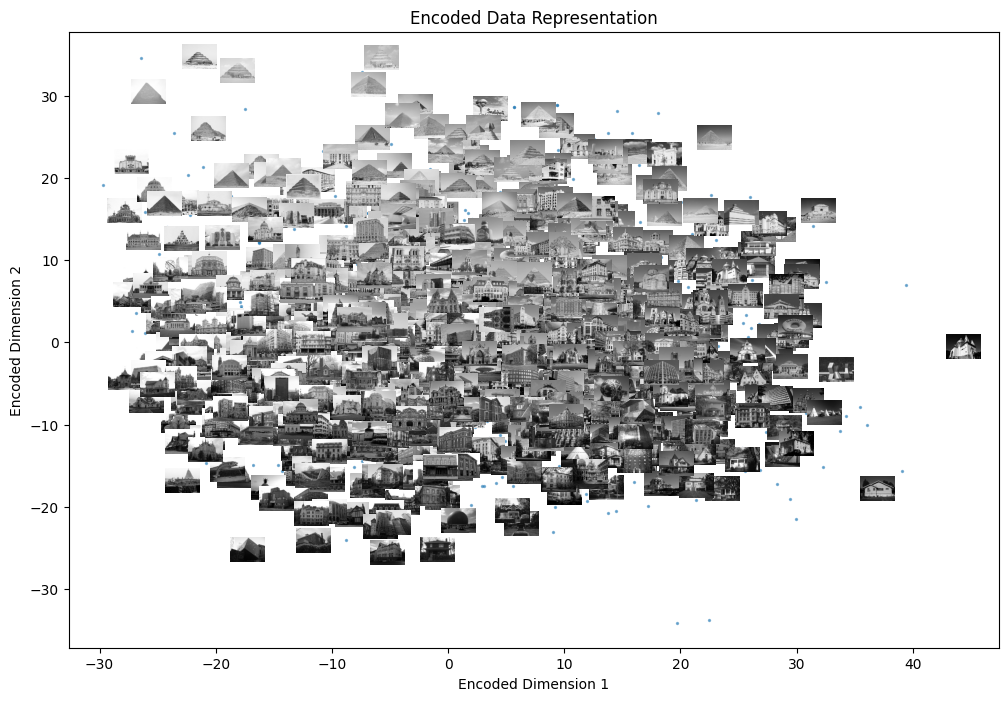

In [28]:
# reshape from flatted vector to 128x128px image
img_reshaped = images_matrix.reshape(2564,128,128)

plot_images_on_scatter(img_reshaped,
                       pca_out[:, 0],
                       pca_out[:, 1],
                       num_samples=1000,
                       thumbnail_scale=3,
                       fig_size=(12, 8))

# [:, 0] -> take the values of the first column (0), for all rows (:)

# Approach 2: umap

### Pros 🌟
1. **Superior at Handling Non-Linear Data**: UMAP shines in understanding the structure of non-linear data, similar to t-SNE, but often with improved speed and scalability. 🚀
2. **Flexible Dimension Reduction**: Highly effective in reducing high-dimensional data into lower dimensions for visualization, often outperforming t-SNE in preserving global structure. 🌍
3. **Consistent Layouts**: Provides more consistent results compared to t-SNE, thanks to its mathematical framework that balances local and global data structure. 🔄

### Cons 🔻
1. **Hyperparameter Sensitivity**: The results of UMAP can be sensitive to the choice of hyperparameters, which may require tuning for optimal performance. 🎛️
2. **Less Intuitive Axis Interpretation**: Similar to t-SNE, the axes in a UMAP plot do not have a clear interpretation, which can make quantitative analysis challenging. 📉
3. **Potential for Overfitting**: UMAP can overfit to noise in the data if not carefully parameterized, potentially misleading interpretations. 🚫

### When to Use 🛠️
- Perfect for exploratory data analysis to uncover the underlying structure and clusters in complex, high-dimensional data. 👀
- Ideal in fields like bioinformatics, text mining, and social network analysis, where preserving the broader data relationship is crucial. 🧬📖🕸️
- Recommended when computational efficiency and consistency across multiple runs are important, albeit with careful attention to hyperparameter settings. 💻



In [ ]:
# import additional libaries
!pip install umap-learn
import umap

In [ ]:
# umap is much slower then PCA, be carefull with the image size! (or use PCA on top!)
images_matrix_umap = np.array([load_and_preprocess_image(img_path,(32,32), flatten=True) for img_path in image_files])

In [ ]:
# Initialize pca  object

In [ ]:
# initializing umap

In [ ]:
# fit umap model
data_umap =

In [ ]:
# add umap ouput as to dataframe by adding two columns
umapDF = pd.DataFrame(data=data_umap, columns=["umap1", "umap2"])
print(umapDF.head())

In [ ]:
# plot original map with clusters
plt.scatter(umapDF['umap1'], umapDF['umap2'], s=2, alpha=0.5)
plt.show()

In [ ]:
print(images_matrix_umap.shape)

(2564, 1024)


In [ ]:
images_matrix_umap_re = images_matrix_umap.reshape(2564,32,32)

plot_images_on_scatter(images_matrix_umap_re,
                       umapDF["umap1"],
                       umapDF["umap2"],
                       num_samples=2500,
                       thumbnail_scale=0.1,
                       fig_size=(48, 32))

# Approach 3 Autoencoders
### Pros 🌟

- **Dimensionality Reduction**: Autoencoders excel at compressing high-dimensional data into a lower-dimensional space, ideal for image embeddings. 📊
- **Feature Extraction**: They automatically learn features from data, useful for unsupervised learning tasks. 🔍
- **Generative Applications**: Capable of generating new data points that are similar to their training data, particularly images. 🎨

### Cons 🔻

- **Complex Architecture Choices**: Selecting the correct network architecture requires careful consideration and testing. 🏗️
- **Potential for Trivial Solutions**: Without proper regularization, autoencoders may fail to learn useful representations. 🔄
- **Computational Intensity**: Training can be resource-intensive, particularly for deep autoencoders. 🖥️

### When to Use 🛠️

- For embedding images into a lower-dimensional space before using algorithms like UMAP for 2D visualization. 🗺️
- In scenarios where you have plenty of unlabeled image data and need to understand underlying patterns or reduce dimensionality. 🖼️
- When you want to pre-train parts of a larger neural network in an unsupervised manner. 🤖

Autoencoders are versatile tools for working with images, especially when the goal is to reduce dimensions before visualization or further analysis.


In [ ]:
# additional imports
from keras.preprocessing.image import load_img, img_to_array

# ANNs
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten


from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


###  Lets built a Artificial Neural Network from scratch*!
*from Keras


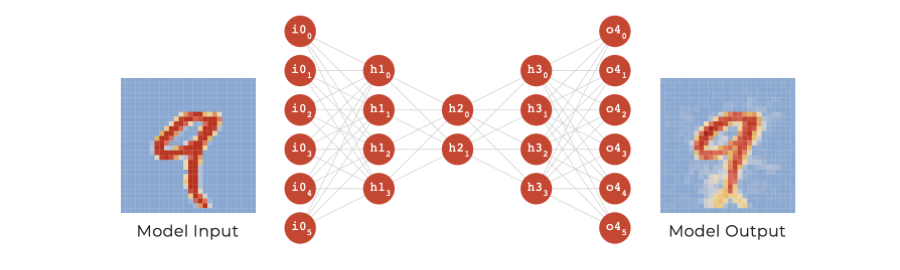

Lets start by actualy building what we see on that image above:

*   an input layer with 6 neurons
*   a inner layer with 4 neurons
*   a bottleneck layer with 2 neurons
*   a dense layer with 4 neurons
*   a final output layer with 6 neurons



In [ ]:
# Keras build blocks
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Reshape, Dense, Flatten

In [ ]:
# Create the Sequential model


# Input layer with 6 neurons


# Inner layer with 4 neurons


# Bottleneck layer with 2 neurons


# Dense layer with 4 neurons


# Output layer with 6 neurons to reconstruct the input


Lets train!

In [ ]:
# lets train the model ... with tiny imagges 3x2 pixels flattent to a 1D array
images_tiny_flat = np.array([load_and_preprocess_image(img_path, (3,2), flatten=True) for img_path in image_files])

In [ ]:
# lets train the model ... with tiny imagges 3x2 pixels flattent to a 1D array
training_history = model.fit(images_tiny_flat, images_tiny_flat, epochs=30, batch_size=8, validation_split=0.1)

In [ ]:
# plot the loss (model accuracy)
training_history
plt.plot(training_history.history['loss'], label='Training loss')
if 'val_loss' in training_history.history:
    plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.show()

**Using the model: encode and plot images**

Since our "bootleneck" layer is set to have 2 dimensions we can extract the values at that layer for each our images and use them for plotting

In [ ]:
# Extract the encoder part of the model
encoder = Model(inputs=model.input, outputs=model.layers[2].output)

# Use the encoder to predict the encoded representation of the data
encoded_data = encoder.predict(images_tiny_flat)


# plot data
plt.scatter(encoded_data[:,0], encoded_data[:,1], alpha=0.7)
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.title('Encoded Data Representation')
plt.show()

In [ ]:
encoded_data.shape

In [ ]:
images_tiny_flat.shape

In [ ]:
#reshape 1D vector back to 3x2 image
reshaped3x2 = images_tiny_flat.reshape(2564,3,2)

# take the first x images from the higher res version
originalImages = images_matrix_umap
print(originalImages.shape)
reshapedImages64x64 = originalImages.reshape((2564,32, 32))

plot_images_on_scatter(reshapedImages64x64,
                       encoded_data[:,0],
                       encoded_data[:,1],
                       num_samples=2000,
                       thumbnail_scale=0.05,
                       fig_size=(24, 24))

### **Save, Load and continue training models**
You can save your traind (or untrained) model including the architecture to disk for reuse, deployment or to continue training (fine-tuning) later.

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# save the model
model.save("theCompleteModel_withWeights.h5")

# save weights only
model.save_weights('weightsOnly.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# load model
loaded_model = load_model('theCompleteModel_withWeights.h5')

In [ ]:
# Continue training
history = loaded_model.fit(images_tiny_flat, images_tiny_flat, epochs=2, batch_size=32, validation_split=0.2)

## Using a bigger model
Instead of a tiny 6-4-2-4-6 network, we will create one that adjusts to the size of the input data (-> images). More over we paramaterize the model a bit so its easy to experiment with different architectures (number and "size" of layers)

We start with a **4096-64-64-2-64-64-4096** setup.

In [ ]:
# load images again
images_medium = np.array([load_and_preprocess_image(img_path, (64,64), flatten=False) for img_path in image_files])

#seperate a few images for evaluating the model
images_medium, images_medium_val = train_test_split(images_medium, test_size=8, random_state=41)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Input parameters
input_shape = (64, 64, 1)  # Images are 64x64 pixels in grayscale
latent_space_dimension = 2
hidden_layer_units = 64
hidden_layers = 2

def create_autoencoder(input_shape, latent_space_dimension, hidden_layer_units, hidden_layers):
    #---------------------- Encoder ----------------------#
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = Flatten()(encoder_input)

    # Build the hidden layers for the encoder
    for _ in range(hidden_layers):
        x = Dense(hidden_layer_units, activation='relu')(x)

    encoder_output = Dense(latent_space_dimension, activation=None, name='encoder_output')(x)
    encoder = Model(encoder_input, encoder_output, name='encoder')

    #---------------------- Decoder ----------------------#
    decoder_input = Input(shape=(latent_space_dimension,), name='decoder_input')
    x = decoder_input

    # Build the hidden layers for the decoder
    for _ in range(hidden_layers):
        x = Dense(hidden_layer_units, activation='relu')(x)

    decoder_output = Dense(input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(x)
    decoder_output_reshaped = Reshape(input_shape)(decoder_output)
    decoder = Model(decoder_input, decoder_output_reshaped, name='decoder')

    #------------------- Full Autoencoder -------------------#
    autoencoder_input = Input(shape=input_shape, name='autoencoder_input')
    encoded_img = encoder(autoencoder_input)
    decoded_img = decoder(encoded_img)
    autoencoder = Model(autoencoder_input, decoded_img, name='autoencoder')

    # Compile the autoencoder model
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder, encoder, decoder



# Create and summarize the autoencoder
autoencoder, encoder, decoder = create_autoencoder(input_shape, latent_space_dimension, hidden_layer_units, hidden_layers)
autoencoder.summary()


In [ ]:
# lets train the model!
loss_history = autoencoder.fit(images_medium, images_medium, epochs=40, batch_size=32, validation_split=0.1)

In [ ]:
# plot the loss (model accuracy)
loss_history
plt.plot(loss_history.history['loss'], label='Training loss')
if 'val_loss' in loss_history.history:
    plt.plot(loss_history.history['val_loss'], label='Validation loss')
plt.show()

**Using the model**

In [ ]:
#lets encode all images
encoded_imgs = encoder.predict(images_medium)

80/80 [==============================] - 0s 2ms/step


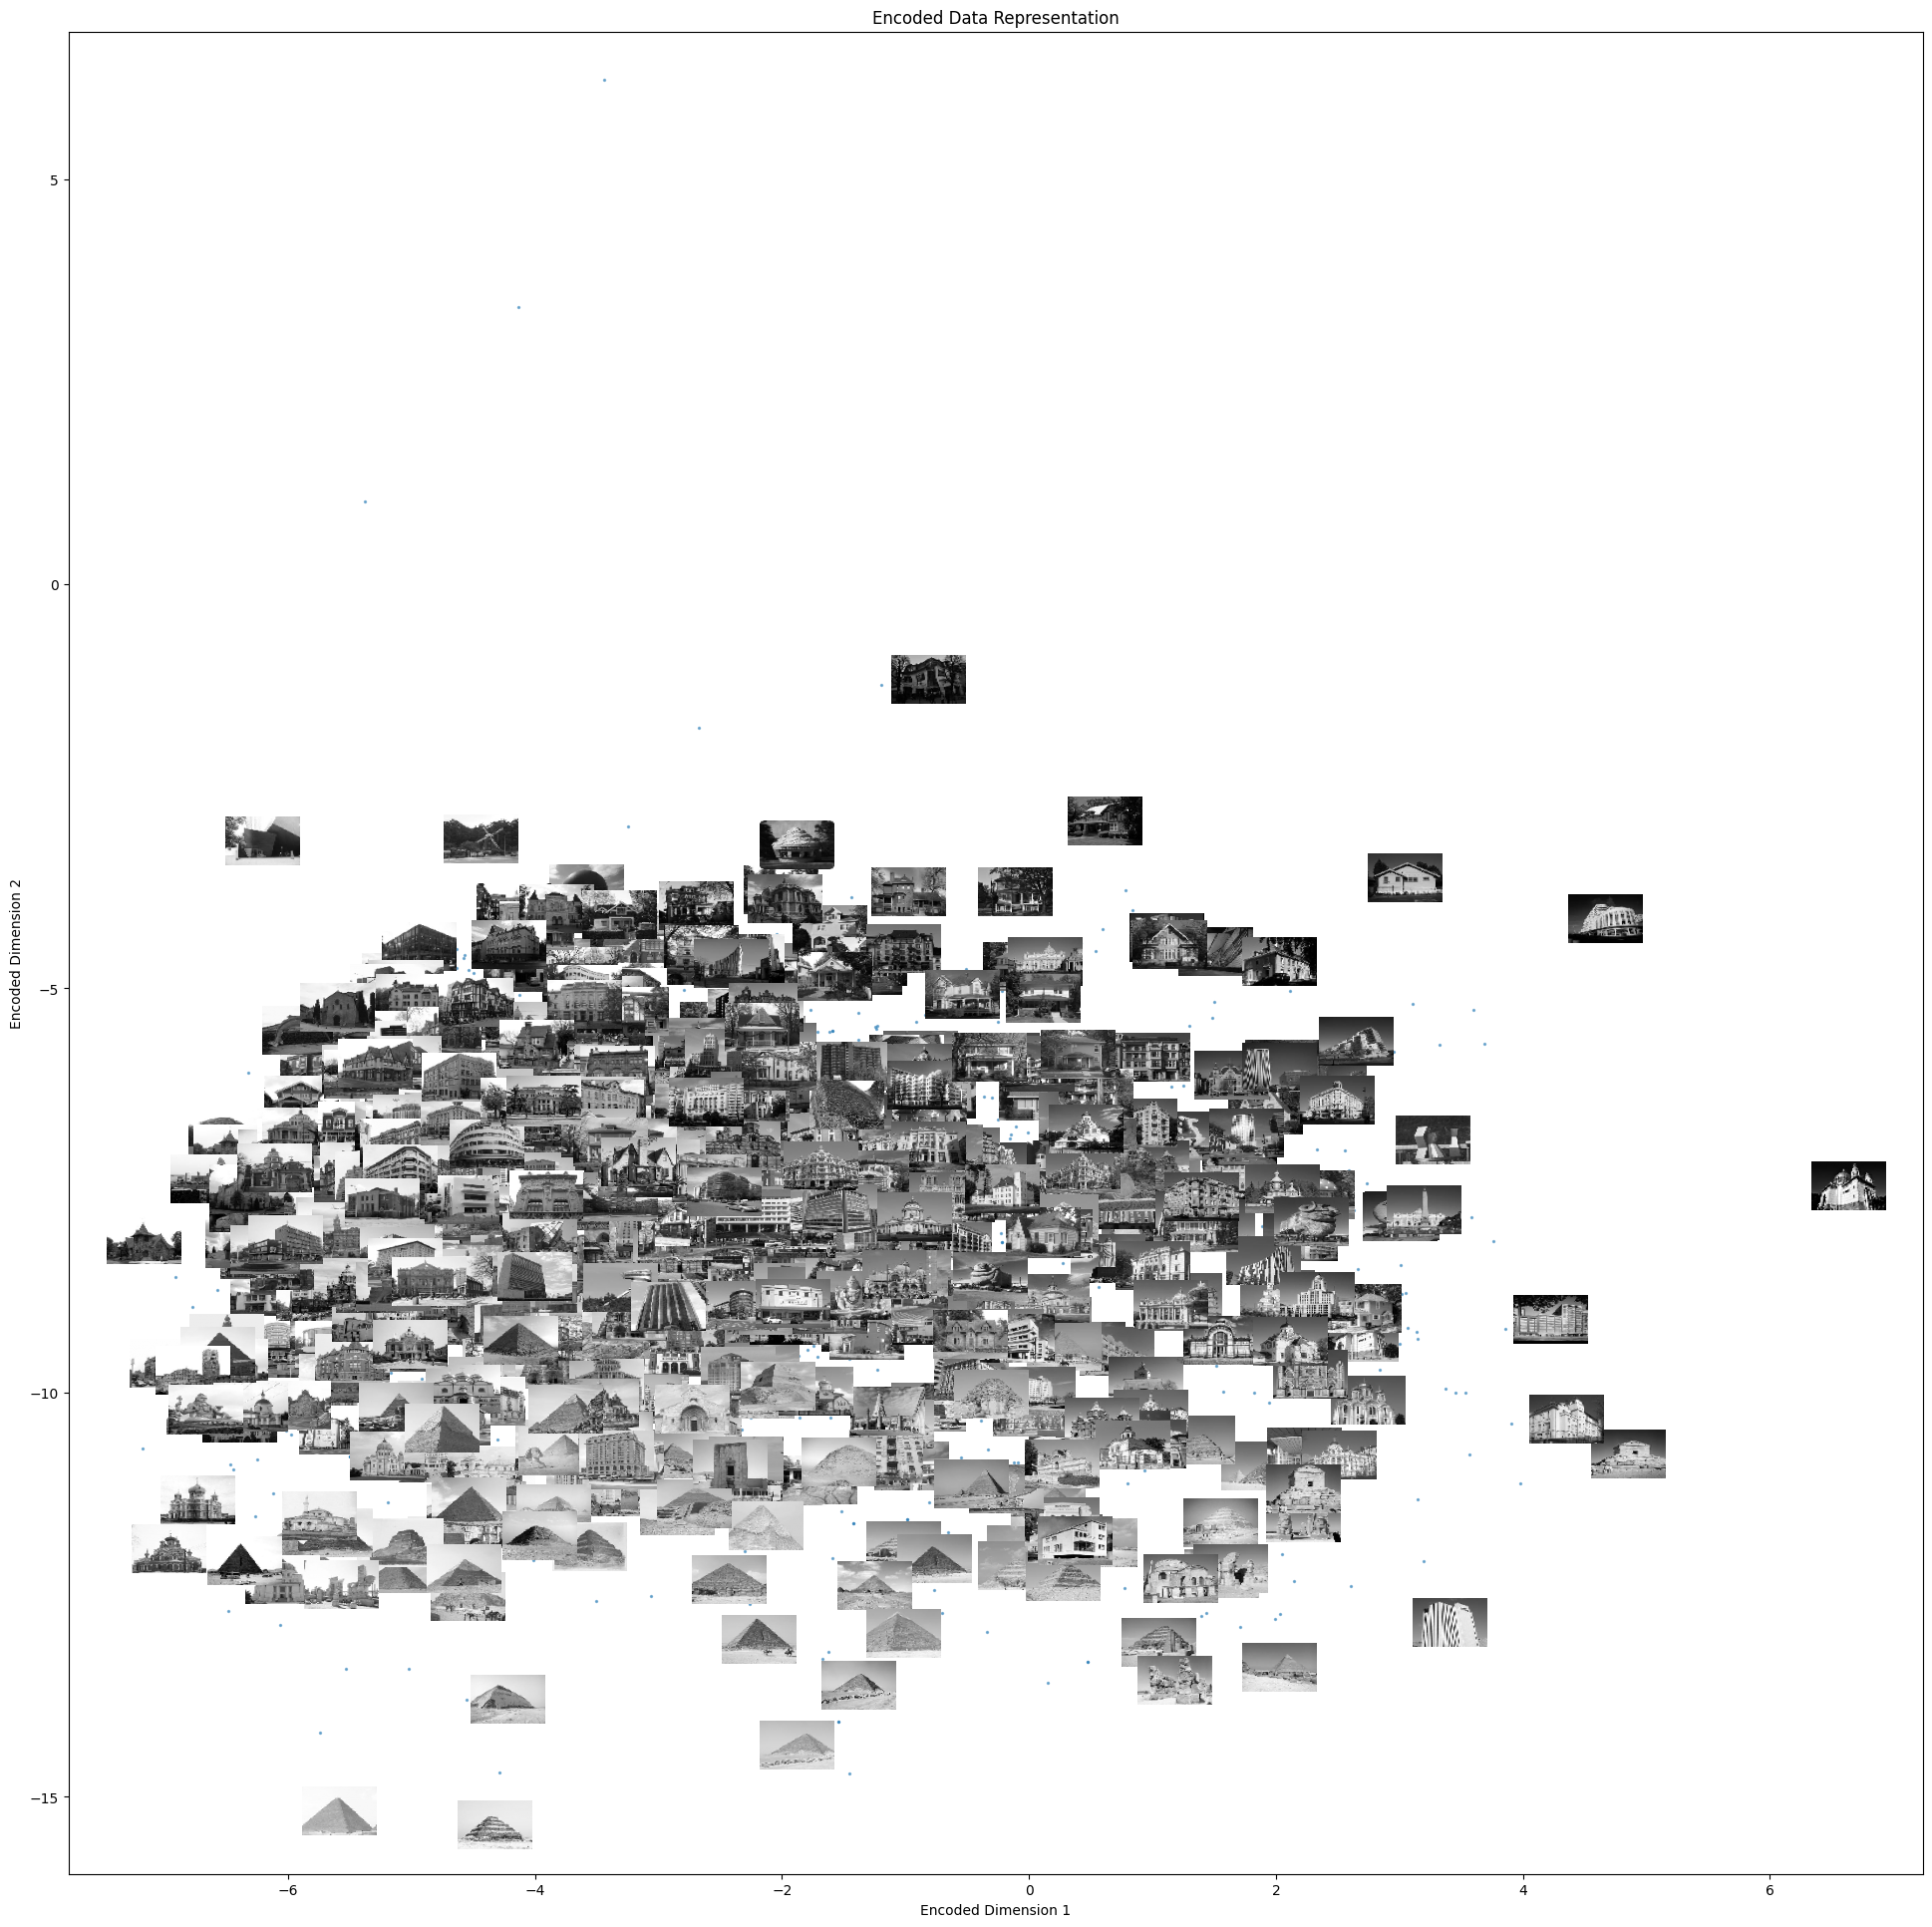

In [ ]:
images_medium_reshaped = images_medium.reshape(2556,64,64)
plot_images_on_scatter(images_medium_reshaped,
                       encoded_imgs[:,0],
                       encoded_imgs[:,1],
                       num_samples=800,
                       thumbnail_scale=0.6,
                       fig_size=(24, 24))

## Experimenting with parameters

In [ ]:
def visualize_all_reconstructions(encoder, decoder, images):
    """
    Encodes and then decodes all images using the provided encoder and decoder models,
    and visualizes the original and reconstructed images.

    Parameters:
    - encoder: The encoder part of the autoencoder.
    - decoder: The decoder part of the autoencoder.
    - images: The images to encode and decode.
    """
    # Encode and decode the images
    encoded_imgs = encoder.predict(images)
    decoded_imgs = decoder.predict(encoded_imgs)

    # Calculate the number of images
    n_images = images.shape[0]

    # Ensure the figure size is manageable, adjust as necessary
    plt.figure(figsize=(20, max(4, n_images // 5)))

    for i in range(n_images):
        # Plot original images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Plot reconstructed images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(decoded_imgs[i].reshape(64, 64), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [ ]:
# lets experiment with model parameter, plot the result and compare the loss
input_shape = (64, 64, 1)
latent_space_dimension = 100
hidden_layer_units = 64
hidden_layers = 4

# initialize auto encoder
autoencoder, encoder, decoder = create_autoencoder(input_shape,
                                                   latent_space_dimension,
                                                   hidden_layer_units,
                                                   hidden_layers)

# train
autoencoder.fit(images_medium, images_medium, epochs=15, batch_size=64, validation_split=0.1)

# run visualisation function
visualize_all_reconstructions(encoder, decoder, images_medium_val)

In [ ]:
# -> encode & visualise decoded/ generated images
images_medium_val

##**Using a Convolutional Neural Network**

In [ ]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose

In [ ]:
# Autoencoder configuration
input_shape = (64, 64, 1)  # Images are 64x64 pixels in grayscale
latent_space_dimension = 256

#---------------------- Encoder ----------------------#
encoder_input = Input(shape=input_shape, name='encoder_input')

# Add convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)  # Downsample
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)  # Further Downsample

# Flatten the output and encode it into the latent space
x = Flatten()(x)
encoder_output = Dense(latent_space_dimension, activation=None, name='encoder_output')(x)

# Create the encoder model
encoderCNN = Model(encoder_input, encoder_output, name='encoder')

#---------------------- Decoder ----------------------#
decoder_inputCNN = Input(shape=(latent_space_dimension,), name='decoder_inputCNN')

# Adjust the decoder's dense layer to map back to the correct shape after additional downsampling
# After two downsampling operations, each halving the dimension, you'll have to adjust the reshape size accordingly.
x = Dense((input_shape[0] // 4) * (input_shape[1] // 4) * 32, activation='relu')(decoder_inputCNN)  # Adjusted for further downsampling
x = Reshape((input_shape[0] // 4, input_shape[1] // 4, 32))(x)  # Adjusted reshape dimensions

# Add convolutional transpose layers
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)  # Upsample
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)  # Further Upsample
decoder_outputCNN = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the decoder model
decoderCNN = Model(decoder_inputCNN, decoder_outputCNN, name='decoder')

#------------------- Full Autoencoder -------------------#
autoencoder_inputCNN = Input(shape=input_shape, name='autoencoder_input')
encoded_img = encoderCNN(autoencoder_inputCNN)
decoded_img = decoderCNN(encoded_img)

autoencoderCNN = Model(autoencoder_inputCNN, decoded_img, name='autoencoder')
autoencoderCNN.compile(optimizer='adam', loss='mean_squared_error')
autoencoderCNN.summary()

In [ ]:
autoencoderCNN.fit(images_medium, images_medium, epochs=25, batch_size=32, validation_split=0.1)

1/1 [==============================] - 0s 97ms/step


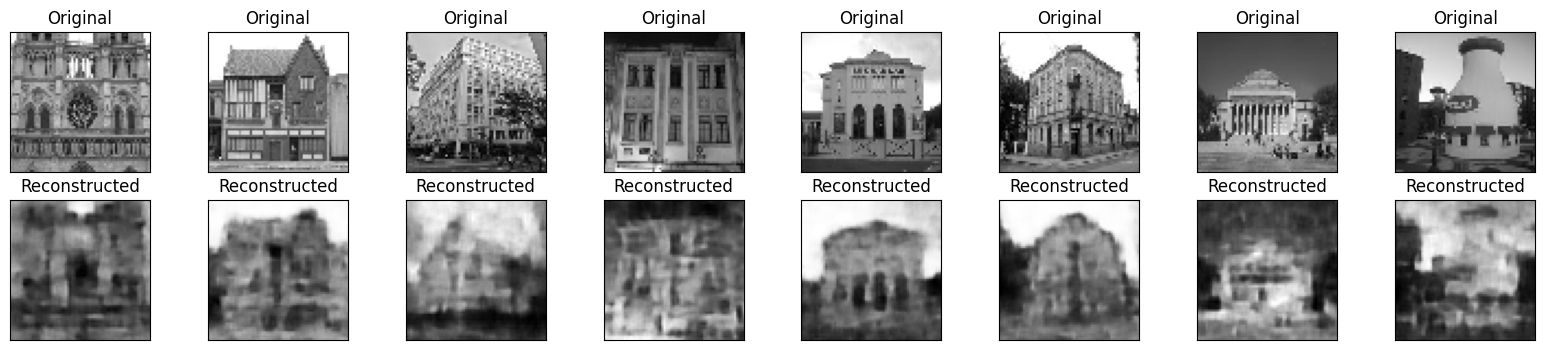

In [ ]:
visualize_all_reconstructions(encoderCNN, decoderCNN, images_medium_val)

###**Use UMAP to plot the images**

In [ ]:
encoded_CNN = encoderCNN(images_medium)

In [ ]:
# initializing tsne
umap_cnn = umap.UMAP(n_components=2,
                     n_neighbors=4,
                     min_dist=0.005,
                     metric='euclidean')
data_umap_cnn = umap_cnn.fit_transform(encoded_CNN)

In [ ]:
encoded_CNN_reshaped = images_medium.reshape(2556,64,64)
plot_images_on_scatter(encoded_CNN_reshaped,
                       data_umap_cnn[:,0],
                       data_umap_cnn[:,1],
                       num_samples=1500,
                       thumbnail_scale=0.1,
                       fig_size=(24, 16))

# Approach 4: Using pre-traiend models
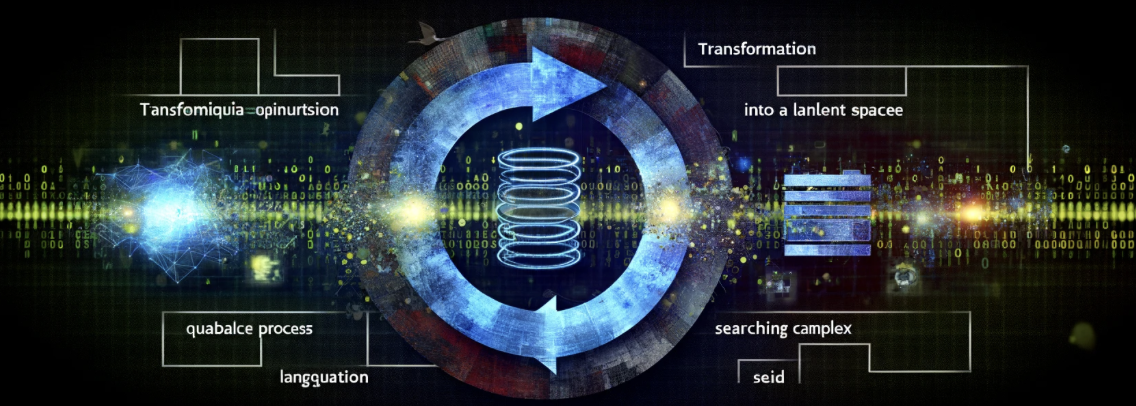

**Goal:** group a s series of images using umap

**Problem:** an RGB image of size 256x256 has ca. 200000 dimensions.
solution: use an autoencoder (specialized for images) to reduce dimensions while maintaining semantic information, apply t-sne or alike algorithms to the so called latent space of the image.

Alternativly we could use image segmentation to quantify images based on the distribution of class labels (e.g. sky, facades, green, number of cars).

**Approach:** we use pre-trained models from hugging face using their transformers libary

### Hugging Face

In [ ]:
# hugging face
!pip install transformers
from transformers import pipeline
from transformers import ViTImageProcessor, ViTModel

# additional libaries
from PIL import Image
import os
import requests
from io import BytesIO
import requests

In [ ]:
images_larger = np.array([load_and_preprocess_image(img_path,(224,224), flatten=False) for img_path in image_files])

In [ ]:
# Testing the pipeline!
image = images_larger[0]
rgb_images = np.repeat(image, 3, axis=-1)

# image encoder model
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# pre-process images
inputs = processor(images=rgb_images, return_tensors="pt")

#run models
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

print (outputs.pooler_output.shape)

torch.Size([1, 768])


In [ ]:
rgb_images.shape

(224, 224, 3)

## Adding embeddings to a dataframe ("database")

In [ ]:
# loop through all images
encoded_images = []
for curImg in images_larger[0:300]:
  rgb_images = np.repeat(curImg, 3, axis=-1)
  # open image and resize (-> model was trained with images of specific size)

  inputs = processor(images=rgb_images, return_tensors="pt")
  outputs = model(**inputs)

  # extract
  latentSpace = outputs.pooler_output.tolist()
  encoded_images.append(latentSpace[0])

In [ ]:
len(encoded_images[0])

768

In [ ]:
# restructure data
image_dict = {}
for i in range(len(encoded_images)):
  image_dict[str(i)] = encoded_images[i]

df_latent = pd.DataFrame.from_dict(image_dict)

# flip matrix (flip columns with rows)
df_latent= df_latent.T
df_latent.head()

0         1         2         3         4         5         6    \
0  0.022260 -0.027234 -0.167344  0.179351 -0.404663  0.285775  0.032376   
1  0.027536 -0.034834 -0.168251  0.179320 -0.402772  0.273378  0.036031   
2  0.024273 -0.032684 -0.167056  0.178849 -0.402664  0.280737  0.038745   
3  0.021978 -0.032137 -0.165853  0.178318 -0.403189  0.279844  0.035597   
4  0.023235 -0.035459 -0.163410  0.177941 -0.405514  0.277399  0.034198   

        7         8         9    ...       758       759       760       761  \
0  0.607737 -0.022518 -0.268904  ... -0.459363  0.123554 -0.504242  0.234287   
1  0.603142 -0.026092 -0.278136  ... -0.462943  0.126944 -0.506488  0.232441   
2  0.603913 -0.024774 -0.274594  ... -0.459291  0.120295 -0.505185  0.235039   
3  0.605412 -0.025127 -0.277498  ... -0.460994  0.125699 -0.506319  0.237413   
4  0.601732 -0.025440 -0.276178  ... -0.463044  0.124444 -0.505246  0.234583   

        762       763       764       765       766       767  
0  0.544567  0.101797 -0.404467  0.261003  0.479955  0.054383  
1  0.547553  0.113816 -0.401341  0.259396  0.484580  0.048900  
2  0.547844  0.107662 -0.402412  0.259952  0.483848  0.051265  
3  0.547039  0.105166 -0.404990  0.259174  0.480418  0.055775  
4  0.549088  0.105324 -0.404773  0.259731  0.484282  0.050766  

[5 rows x 768 columns]

### todo

In [ ]:
import math

def dot_product(list1, list2):
    return sum([x * y for x, y in zip(list1, list2)])


def magnitude(vector):
    return math.sqrt(sum(x ** 2 for x in vector))

def cosine_similarity(list1, list2):
    dot_prod = dot_product(list1, list2)
    mag_list1 = magnitude(list1)
    mag_list2 = magnitude(list2)
    if mag_list1 == 0 or mag_list2 == 0:
        return 0  # Avoid division by zero
    return dot_prod / (mag_list1 * mag_list2)

In [ ]:
# test image embedding
inputs = processor(images=rgb_images, return_tensors="pt")
outputs = model(**inputs)
# extract
latentSpace = outputs.pooler_output.tolist()[0]

# Initialize the maximum similarity and the index of the most similar embedding
max_similarity = -1  # Since cosine similarity ranges from -1 to 1
most_similar_index = None


print(type(latentSpace))
# Iterate through each row in the DataFrame to compute similarities
for index, row in df_latent.iterrows():
    row_values = row.values.tolist()
    # Now attempt to calculate similarity and catch any TypeErrors
    try:
        similarity = cosine_similarity(list(latentSpace), list(row_values))
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_index = index
    except TypeError as e:
        print("TypeError encountered:", e)
        break  # Break the loop to inspect the problem

# Output the result
print(f"Most similar embedding index: {most_similar_index}")
print(f"Maximum cosine similarity: {max_similarity}")



## Visualising embedded images with UMAP
visualising the images in a 2D spcae

In [ ]:
df_latent.values

In [ ]:
# initializing umap
umap_pre = umap.UMAP(n_components=2,
                     n_neighbors=6,
                     min_dist=0.02,
                     metric='euclidean')
data_umap_pre = umap_pre.fit_transform(df_latent.values )

In [ ]:
images_larger.shape

(250, 2)

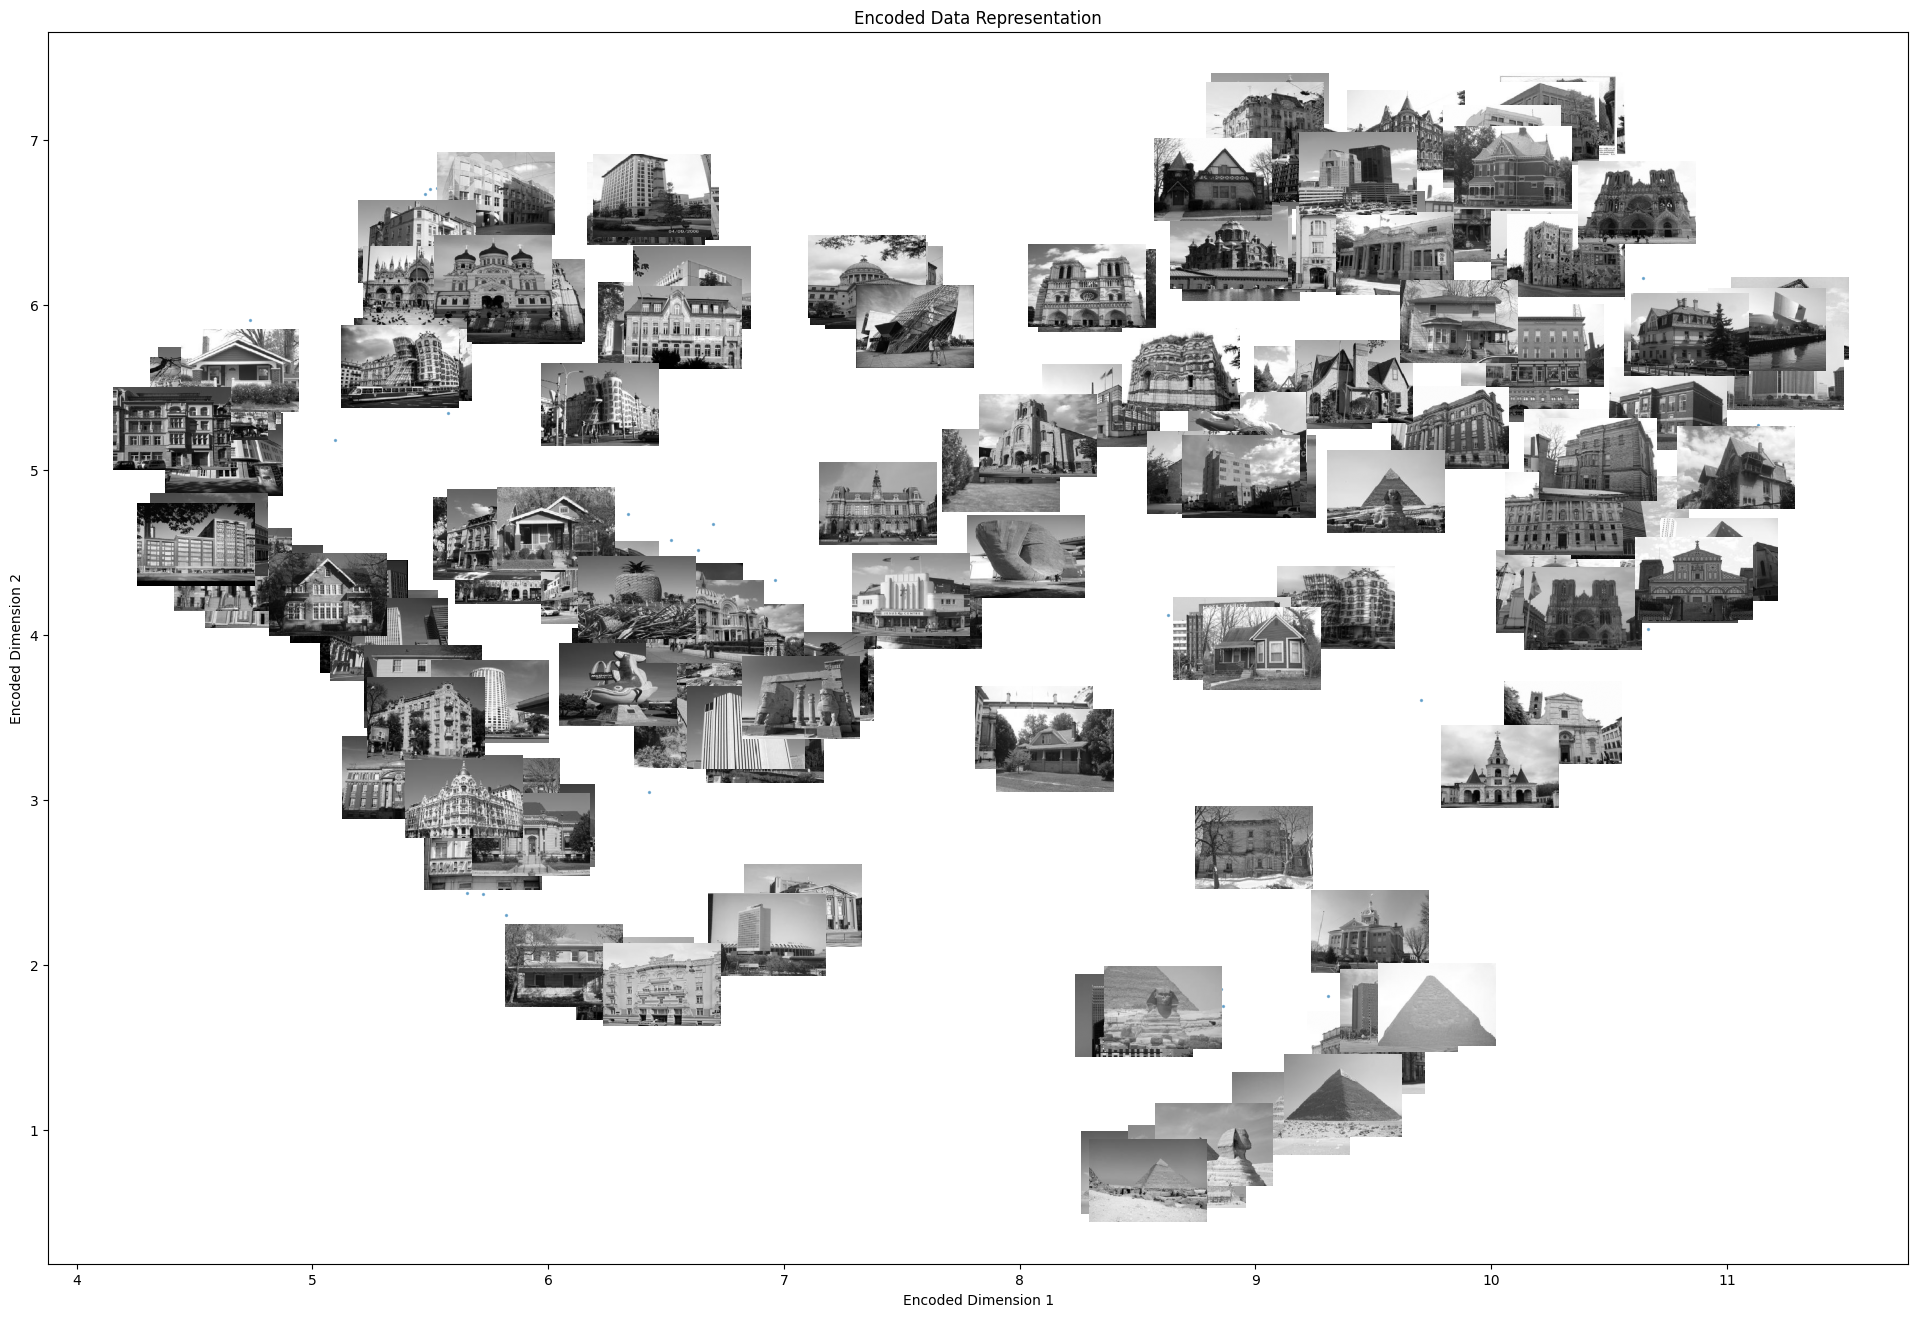

In [ ]:
encoded_pre_reshaped = images_larger[:300].reshape(300,224,224)
plot_images_on_scatter(encoded_pre_reshaped,
                       data_umap_pre[:,0],
                       data_umap_pre[:,1],
                       num_samples=150,
                       thumbnail_scale=0.5,
                       fig_size=(24, 16))